In [1]:
import torch
import torchaudio
import torch.nn as nn
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
from datetime import datetime
import numpy as np
from multiprocessing import cpu_count

c:\Users\nyonk\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
DEVICE = 'cuda:0'
DATA = "mnist"
MODEL_PATH = "models/"
EPOCHS = 420
LABEL = None
TIMESTEPS = 1000
INITIAL_DIM = 32
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 200
INITIAL_LR = 1e-5

## WandB Config

In [3]:
wandb.login()

run = wandb.init(
    project="conifdent-diffusion",
    config={
        "Epochs": EPOCHS,
        "Timesteps": TIMESTEPS,
        "Initial Conv Dim": INITIAL_DIM,
        "Image Size": IMAGE_SIZE,
        "Batch Size": BATCH_SIZE
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ulriks9 (confident-diffusion). Use `wandb login --relogin` to force relogin


## Data

#### MNIST Dataset:

In [4]:
class SpectrogramYESNO(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = torchaudio.datasets.YESNO(
            root="train_yesno/",
            download=True
            )
        
        self.transform = torch.nn.Sequential(
            torchaudio.transforms.Spectrogram()
        )
        
    def __getitem__(self, idx):
        waveform, sample_rate, label = self.dataset[idx]
        spectrogram = self.transform(waveform)

        print(spectrogram.shape)

        return (
            spectrogram,
            sample_rate,
            label
        )
    
    def __len__(self):
        return len(self.dataset)

In [5]:
if DATA == "mnist":
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=IMAGE_SIZE, antialias=True)
        ])

    dataset = datasets.MNIST(
        root="train_mnist/",
        train=True,
        download=True,
        transform=preprocess
        )

#### GTZAN Dataset:

In [6]:
if DATA == "YESNO":
    dataset = SpectrogramYESNO()

#### Filter out classes:

In [7]:
if LABEL is not None:
    idx = dataset.targets == LABEL
    dataset.targets = dataset.targets[idx]
    dataset.data = dataset.data[idx]

#### Set up:

In [8]:
dl = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
    )

(1, 32, 32)


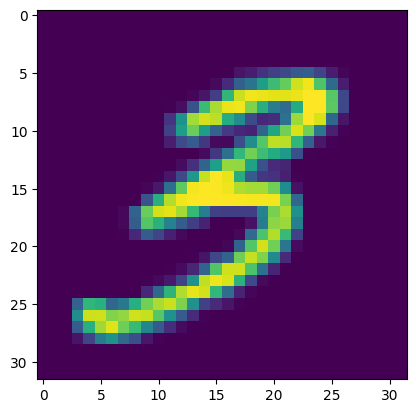

In [9]:
example_image = next(iter(dl))[0][0].numpy()
print(example_image.shape)
plt.imshow(example_image.transpose((1, 2, 0)))
plt.show()

## Model

In [10]:
def get_model():
    model = Unet(
        dim=INITIAL_DIM,
        dim_mults = (1, 2, 4, 8),
        channels=1
        ).to(DEVICE)
    
    diffusion = GaussianDiffusion(
        model,
        image_size=IMAGE_SIZE[0],
        timesteps=TIMESTEPS,
        loss_type='l1'
        ).to(DEVICE)
    
    return diffusion

## Training

In [11]:
best_loss = float("inf")
diffusion = get_model()
models_saved = 0
diffusion.train()
optimizer = torch.optim.AdamW(diffusion.parameters(), INITIAL_LR)

for epoch in range(EPOCHS):
    pbar = tqdm(dl, leave=True, desc=f"Epoch {epoch + 1}/{EPOCHS}", colour="#55D3FF")

    for batch in pbar:
        batch = batch[0].to(DEVICE)
        loss = diffusion(batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        logs = {"loss": loss.detach().item()}
        pbar.set_postfix(**logs)
        wandb.log({"loss": loss.detach().item()})

    epoch_loss = loss.detach().item()
    if epoch_loss < best_loss:
        torch.save({"model_state_dict": diffusion.state_dict()}, MODEL_PATH + "model.pt")
        best_loss = epoch_loss
        print("INFO: New model saved.")
        models_saved += 1
        wandb.log({"models_saved": models_saved})

Epoch 1/420: 100%|██████████| 300/300 [01:18<00:00,  3.84it/s, loss=0.325]


INFO: New model saved.


Epoch 2/420: 100%|██████████| 300/300 [01:14<00:00,  4.04it/s, loss=0.231]


INFO: New model saved.


Epoch 3/420: 100%|██████████| 300/300 [01:14<00:00,  4.03it/s, loss=0.177]


INFO: New model saved.


Epoch 4/420: 100%|██████████| 300/300 [01:15<00:00,  4.00it/s, loss=0.171]


INFO: New model saved.


Epoch 5/420: 100%|██████████| 300/300 [01:13<00:00,  4.11it/s, loss=0.135]


INFO: New model saved.


Epoch 6/420: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s, loss=0.131]


INFO: New model saved.


Epoch 7/420: 100%|██████████| 300/300 [01:13<00:00,  4.10it/s, loss=0.125]


INFO: New model saved.


Epoch 8/420: 100%|██████████| 300/300 [01:13<00:00,  4.11it/s, loss=0.113]


INFO: New model saved.


Epoch 10/420: 100%|██████████| 300/300 [01:15<00:00,  3.99it/s, loss=0.107]


INFO: New model saved.


Epoch 12/420: 100%|██████████| 300/300 [01:15<00:00,  3.98it/s, loss=0.105] 


INFO: New model saved.


Epoch 14/420: 100%|██████████| 300/300 [01:14<00:00,  4.02it/s, loss=0.103] 


INFO: New model saved.


Epoch 15/420: 100%|██████████| 300/300 [01:15<00:00,  3.95it/s, loss=0.0986]


INFO: New model saved.


Epoch 17/420: 100%|██████████| 300/300 [01:15<00:00,  3.96it/s, loss=0.0914]


INFO: New model saved.


Epoch 22/420: 100%|██████████| 300/300 [01:15<00:00,  4.00it/s, loss=0.0895]


INFO: New model saved.


Epoch 23/420: 100%|██████████| 300/300 [01:12<00:00,  4.11it/s, loss=0.0892]


INFO: New model saved.


Epoch 24/420:  98%|█████████▊| 294/300 [01:13<00:01,  4.01it/s, loss=0.0902]


KeyboardInterrupt: 

## Inference

sampling loop time step: 100%|██████████| 1000/1000 [00:29<00:00, 33.77it/s]


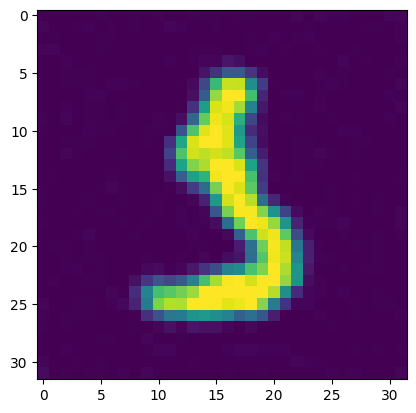

In [14]:
diffusion = get_model().to(DEVICE)
checkpoint = torch.load("models/model.pt")
diffusion.load_state_dict(checkpoint["model_state_dict"])
sampled_images = diffusion.sample(batch_size=1)
for image in sampled_images:
    image = image.cpu().detach().numpy()
    image = image.transpose((1,2,0))

    plt.imshow(image)
    plt.show()